# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
def savefile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp
from tqdm import tqdm
import os

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

In [2]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [3]:


final["Time"] = pd.to_datetime(final["Time"] , unit = "s")
reviews_timesorted = final.sort_values(by = "Time")
print (reviews_timesorted.shape)
reviews_timesorted_score = reviews_timesorted["Score"]
print (reviews_timesorted_score.shape)
reviews_timesorted.head(5)

(364171, 12)
(364171,)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [4]:

reviews_100k = reviews_timesorted.head(100000)
print (reviews_100k.shape)


reviews_100k_score = reviews_100k["Score"]
print (reviews_100k_score.shape)

reviews_100k.head()



(100000, 12)
(100000,)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [38]:
from sklearn import model_selection

reviews_train, reviews_test, reviews_score_train , reviews_score_test = model_selection.train_test_split(reviews_100k, reviews_100k_score, test_size=0.3, random_state=0)
print (reviews_train.shape)
print (reviews_score_train.shape)
print (reviews_test.shape)
print (reviews_score_test.shape)

(70000, 12)
(70000,)
(30000, 12)
(30000,)


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3137.37it/s]


In [0]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [6]:
count_vect = CountVectorizer() #in scikit-learn
reviews_train_bow = count_vect.fit_transform(reviews_train['CleanedText'].values)
# reviews_cv_bow = count_vect.transform(reviews_cv['CleanedText'].values)
reviews_test_bow = count_vect.transform(reviews_test['CleanedText'].values)

print("the type of count vectorizer ",type(reviews_train_bow))
print (reviews_train_bow.shape)
# print (reviews_cv_bow.shape)
print (reviews_test_bow.shape)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
(70000, 31572)
(30000, 31572)


In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV , TimeSeriesSplit
from sklearn.model_selection import cross_val_score
    
    
clf = DecisionTreeClassifier(  class_weight = 'balanced' )
param_grid = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split' : [5, 10, 100, 500] }
#Using GridSearchCV
model = GridSearchCV(clf, param_grid, scoring = 'roc_auc', cv=5 , verbose=1 , n_jobs=-2)
model.fit(reviews_train_bow, reviews_score_train)
savefile(model,"GridSearch_BoW_Linear_SVM")
print(model.best_estimator_)
print(model.score(reviews_train_bow, reviews_score_train))    
# weight = model.coef_
    
 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-2)]: Done 140 out of 140 | elapsed: 11.4min finished


DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.9047793585169283


{'max_depth': 50, 'min_samples_split': 500}


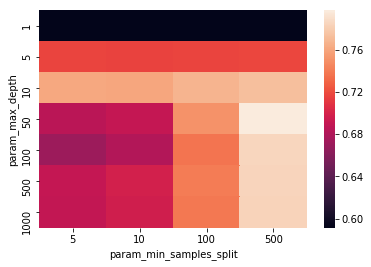

In [101]:
gsv = openfile('GridSearch_BoW_Linear_SVM')
print (gsv.best_params_)
pvt = pd.pivot_table(pd.DataFrame(gsv.cv_results_),values='mean_test_score', index='param_max_depth', columns='param_min_samples_split')
sns.heatmap(pvt)

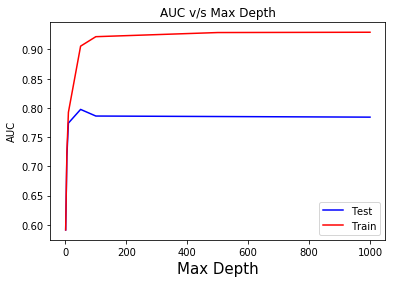

In [21]:
gsv = openfile('GridSearch_BoW_Linear_SVM')

x1=[]
y1=[]
x2=[]
y2=[]
gsv.cv_results_
means = gsv.cv_results_['mean_test_score']
means_train = gsv.cv_results_['mean_train_score']
stds = gsv.cv_results_['std_test_score']
for mean, mean_train ,  std, params in zip(means, means_train,stds, gsv.cv_results_['params']):

    if params['min_samples_split'] == 500:
        x1.append(params['max_depth'])
        y1.append(mean)
        x2.append(params['max_depth'])
        y2.append(mean_train)

        

plt.xlabel("Max Depth",fontsize=15)
plt.ylabel("AUC")
plt.title('AUC v/s Max Depth')

plt.plot(x1,y1,'b',label="Test")
plt.plot(x2,y2,'r',label="Train")
plt.legend()
plt.show()

In [81]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
model = DecisionTreeClassifier(class_weight = 'balanced' , max_depth=50 , min_samples_split=500)

# fitting the model
model.fit(reviews_train_bow , reviews_score_train)

# predict the response
pred = model.predict(reviews_train_bow)

# evaluate accuracy
acc = accuracy_score(reviews_score_train, pred) * 100
print('\nThe accuracy of the Decision Tree for max_depth = %f is %f%%' % (50, acc))


The accuracy of the Decision Tree for max_depth = 50.000000 is 77.347143%


AUC: 0.905


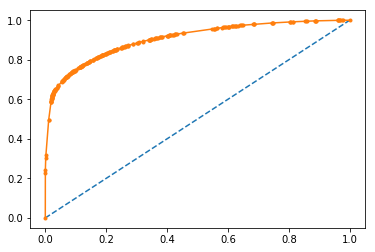

In [90]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot

#Getting AUC value from calibrated model . 
probs = model.predict_proba(reviews_train_bow)
probs = probs[:, 1]
auc = roc_auc_score(reviews_score_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(reviews_score_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

[[ 7680   926]
 [14931 46463]]


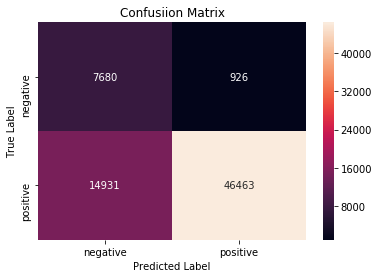

In [91]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(reviews_score_train, pred)
print (conf_matrix)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [92]:
from sklearn.metrics import classification_report
print (classification_report(reviews_score_train, pred))

              precision    recall  f1-score   support

           0       0.34      0.89      0.49      8606
           1       0.98      0.76      0.85     61394

   micro avg       0.77      0.77      0.77     70000
   macro avg       0.66      0.82      0.67     70000
weighted avg       0.90      0.77      0.81     70000



In [102]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
model = DecisionTreeClassifier(class_weight = 'balanced' , max_depth=50 , min_samples_split=500)

# fitting the model
model.fit(reviews_test_bow , reviews_score_test)

# predict the response
pred = model.predict(reviews_test_bow)

# evaluate accuracy
acc = accuracy_score(reviews_score_test, pred) * 100
print('\nThe accuracy of the Decision Tree for max_depth = %f is %f%%' % (50, acc))


The accuracy of the Decision Tree for max_depth = 50.000000 is 74.060000%


AUC: 0.895


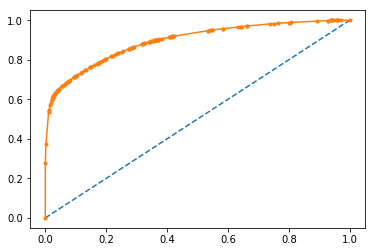

In [103]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot

#Getting AUC value from calibrated model . 
probs = model.predict_proba(reviews_test_bow)
probs = probs[:, 1]
auc = roc_auc_score(reviews_score_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(reviews_score_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

[[ 3291   374]
 [ 7408 18927]]


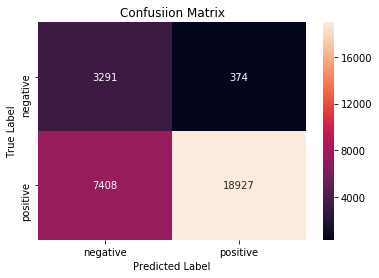

In [104]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(reviews_score_test, pred)
print (conf_matrix)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [106]:
from sklearn.metrics import classification_report
print (classification_report(reviews_score_test, pred))

              precision    recall  f1-score   support

           0       0.31      0.90      0.46      3665
           1       0.98      0.72      0.83     26335

   micro avg       0.74      0.74      0.74     30000
   macro avg       0.64      0.81      0.64     30000
weighted avg       0.90      0.74      0.78     30000



### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [46]:
log_prob_reviews = np.array([model.feature_importances_])
tfidf_features = count_vect.get_feature_names()

print (log_prob_reviews.shape)
print (len(tfidf_features))

(1, 31572)
31572


In [47]:
feature_prob = pd.DataFrame(log_prob_reviews,columns=tfidf_features)
feature_prob_transpose = feature_prob.T


In [48]:
print("\n\n  Top 20 Features:-\n",feature_prob_transpose[0].sort_values(ascending = False)[0:20])




  Top 20 Features:-
 great         0.107553
best          0.066661
disappoint    0.057750
love          0.050787
delici        0.042942
bad           0.027673
excel         0.022287
favorit       0.020447
good          0.019906
perfect       0.017578
tast          0.016095
money         0.014736
nice          0.013701
product       0.012293
terribl       0.011459
would         0.010767
worst         0.010637
wonder        0.010317
thought       0.009928
howev         0.009848
Name: 0, dtype: float64


### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [53]:
import graphviz 
from sklearn import tree
dot_data = tree.export_graphviz(model , out_file=None , feature_names=count_vect.get_feature_names()   ,  max_depth=3) 
graph = graphviz.Source(dot_data) 
graph.render('test_bow') 

'test_bow.pdf'

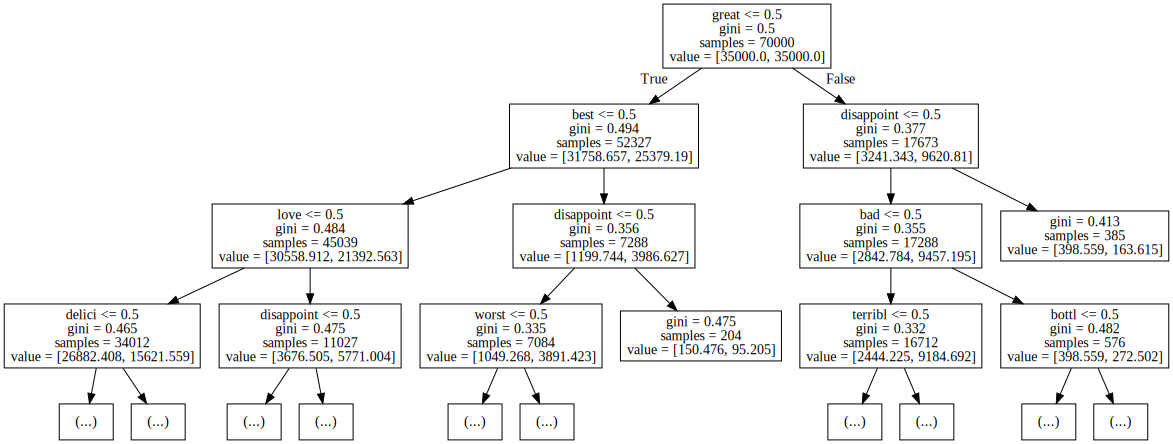

In [54]:
import graphviz 
from sklearn import tree
dot_data = tree.export_graphviz(model , out_file=None , feature_names=count_vect.get_feature_names() ,   max_depth=3) 
graph = graphviz.Source(dot_data)
graph

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [47]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
reviews_train_tfidf = tf_idf_vect.fit_transform(reviews_train['CleanedText'].values)

reviews_test_tfidf = tf_idf_vect.transform(reviews_test['CleanedText'].values)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score
    
    
clf = DecisionTreeClassifier(  class_weight = 'balanced' )
param_grid = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split' : [5, 10, 100, 500] }
#Using GridSearchCV
model = GridSearchCV(clf, param_grid, scoring = 'roc_auc', cv=5 , verbose=1 , n_jobs=-1)
model.fit(reviews_train_tfidf, reviews_score_train)
savefile(model,"GridSearch_tfidf_Decision_Tree")
print(model.best_estimator_)
print(model.score(reviews_train_tfidf, reviews_score_train))    
# weight = model.coef_
    
 

{'max_depth': 50, 'min_samples_split': 500}


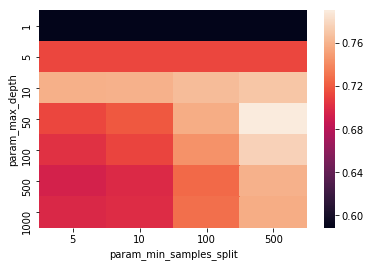

In [107]:
gsv = openfile('GridSearch_tfidf_Decision_Tree')
print (gsv.best_params_)
pvt = pd.pivot_table(pd.DataFrame(gsv.cv_results_),values='mean_test_score', index='param_max_depth', columns='param_min_samples_split')
sns.heatmap(pvt)

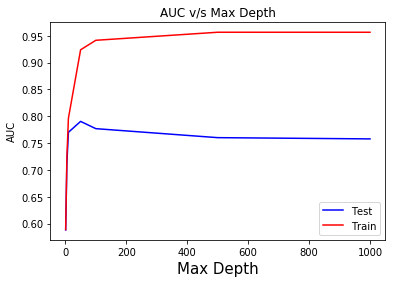

In [22]:
gsv = openfile('GridSearch_tfidf_Decision_Tree')

x1=[]
y1=[]
x2=[]
y2=[]
gsv.cv_results_
means = gsv.cv_results_['mean_test_score']
means_train = gsv.cv_results_['mean_train_score']
stds = gsv.cv_results_['std_test_score']
for mean, mean_train ,  std, params in zip(means, means_train,stds, gsv.cv_results_['params']):

    if params['min_samples_split'] == 500:
        x1.append(params['max_depth'])
        y1.append(mean)
        x2.append(params['max_depth'])
        y2.append(mean_train)

        

plt.xlabel("Max Depth",fontsize=15)
plt.ylabel("AUC")
plt.title('AUC v/s Max Depth')

plt.plot(x1,y1,'b',label="Test")
plt.plot(x2,y2,'r',label="Train")
plt.legend()
plt.show()

In [108]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
model = DecisionTreeClassifier(class_weight = 'balanced' , max_depth=50 , min_samples_split=500)
gsv = openfile('GridSearch_tfidf_Decision_Tree')
print (gsv.best_params_)
# fitting the model
model.fit(reviews_train_tfidf , reviews_score_train)

# predict the response
pred = model.predict(reviews_train_tfidf)

# evaluate accuracy
acc = accuracy_score(reviews_score_train, pred) * 100
print('\nThe accuracy of the Decision Tree for max_depth = %f is %f%%' % (50, acc))

{'max_depth': 50, 'min_samples_split': 500}

The accuracy of the Decision Tree for max_depth = 50.000000 is 80.604286%


AUC: 0.925


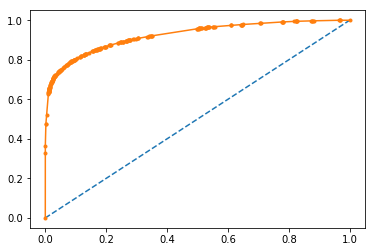

In [110]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot

#Getting AUC value from calibrated model . 
probs = model.predict_proba(reviews_train_tfidf)
probs = probs[:, 1]
auc = roc_auc_score(reviews_score_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(reviews_score_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

[[ 7878   728]
 [12849 48545]]


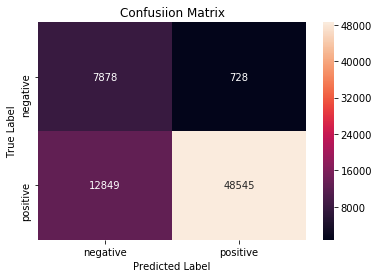

In [111]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(reviews_score_train, pred)
print (conf_matrix)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [112]:
from sklearn.metrics import classification_report
print (classification_report(reviews_score_train, pred))

              precision    recall  f1-score   support

           0       0.38      0.92      0.54      8606
           1       0.99      0.79      0.88     61394

   micro avg       0.81      0.81      0.81     70000
   macro avg       0.68      0.85      0.71     70000
weighted avg       0.91      0.81      0.84     70000



In [113]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
model = DecisionTreeClassifier(class_weight = 'balanced' , max_depth=50 , min_samples_split=500)
gsv = openfile('GridSearch_tfidf_Decision_Tree')
print (gsv.best_params_)
# fitting the model
model.fit(reviews_test_tfidf , reviews_score_test)

# predict the response
pred = model.predict(reviews_test_tfidf)

# evaluate accuracy
acc = accuracy_score(reviews_score_test, pred) * 100
print('\nThe accuracy of the Decision Tree for max_depth = %f is %f%%' % (50, acc))

{'max_depth': 50, 'min_samples_split': 500}

The accuracy of the Decision Tree for max_depth = 50.000000 is 80.310000%


AUC: 0.918


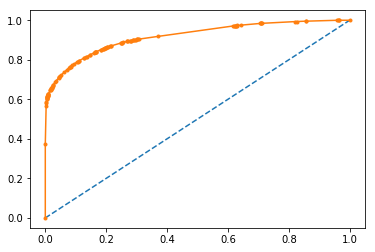

In [114]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot

#Getting AUC value from calibrated model . 
probs = model.predict_proba(reviews_test_tfidf)
probs = probs[:, 1]
auc = roc_auc_score(reviews_score_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(reviews_score_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

[[ 3277   388]
 [ 5519 20816]]


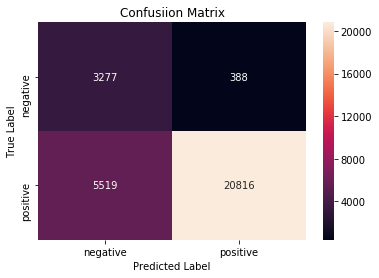

In [115]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(reviews_score_test, pred)
print (conf_matrix)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [116]:
from sklearn.metrics import classification_report
print (classification_report(reviews_score_test, pred))

              precision    recall  f1-score   support

           0       0.37      0.89      0.53      3665
           1       0.98      0.79      0.88     26335

   micro avg       0.80      0.80      0.80     30000
   macro avg       0.68      0.84      0.70     30000
weighted avg       0.91      0.80      0.83     30000



### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [31]:
log_prob_reviews = np.array([model.feature_importances_])
tfidf_features = tf_idf_vect.get_feature_names()

print (log_prob_reviews.shape)
print (len(tfidf_features))

(1, 932590)
932590


In [39]:
feature_prob = pd.DataFrame(log_prob_reviews,columns=tfidf_features)
feature_prob_transpose = feature_prob.T


In [42]:
print("\n\n  Top 20 Features:-\n",feature_prob_transpose[0].sort_values(ascending = False)[0:20])




  Top 20 Features:-
 great             0.104704
best              0.064226
love              0.053861
disappoint        0.047356
delici            0.041879
good              0.022206
favorit           0.022137
excel             0.022029
perfect           0.019383
high recommend    0.015099
nice              0.015061
bad               0.014978
tast              0.012372
thought           0.010979
find              0.010425
money             0.009744
tasti             0.009175
wonder            0.009158
terribl           0.008619
enjoy             0.008184
Name: 0, dtype: float64


### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [48]:
import graphviz 
from sklearn import tree
dot_data = tree.export_graphviz(model , out_file=None , feature_names=tf_idf_vect.get_feature_names() ,  max_depth=3) 
graph = graphviz.Source(dot_data) 
graph.render('test_tfidf') 

'test_tfidf.pdf'

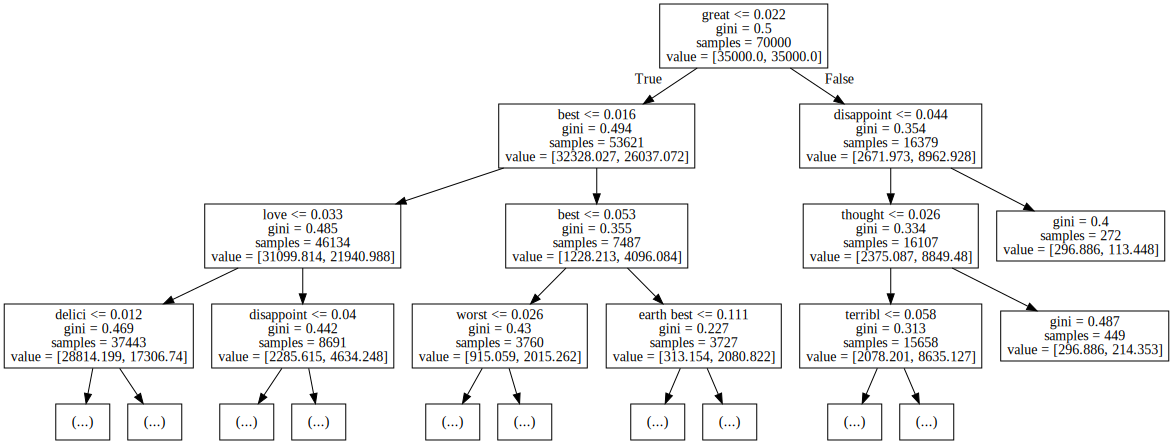

In [50]:
import graphviz 
from sklearn import tree
dot_data = tree.export_graphviz(model , out_file=None , feature_names=tf_idf_vect.get_feature_names() ,  max_depth=3) 
graph = graphviz.Source(dot_data)
graph

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [55]:
i=0
list_of_sent =[]
for sent in reviews_100k['CleanedText'].values:
    list_of_sent.append(sent.split())

In [56]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=300, workers=4)

In [57]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12508
sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'preschool']


In [63]:
sent_vectors = [] #List to store all the avg w2vec's 

for sent in tqdm(reviews_100k['CleanedText']):
    cnt = 0 #to count no of words in each reviews
    sent_vec = np.zeros(300) #Initializing with zeroes
#     print("sent:",sent) 
#     sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
#             print(word)
            wvec = w2v_model.wv[word] #Vector of each using w2v model
#             print("wvec:",wvec)
            sent_vec += wvec #Adding the vectors
#             print("sent_vec:",sent_vec)
            cnt += 1
        except: 
            pass #When the word is not in the dictionary then do nothing  
#     print(sent_vec)
    sent_vec /= cnt 
    sent_vectors.append(sent_vec) 
sent_vectors = np.array(sent_vectors)
savefile(sent_vectors , 'AvgW2V_Decision_Tree_2')

100%|██████████| 100000/100000 [00:17<00:00, 5871.19it/s]


In [64]:
sent_vectors = openfile('AvgW2V_Decision_Tree_2')
# print (sent_vectors[0])
sent_vectors = np.array(sent_vectors)
print (reviews_100k_score.shape)
print (sent_vectors.shape)

(100000,)
(100000, 300)


In [65]:
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
# reviews_std_w2v = StandardScaler(with_mean = False).fit_transform(sent_vectors)
    
reviews_train_w2v, reviews_test_w2v, reviews_score_train_w2v , reviews_score_test_w2v = model_selection.train_test_split(sent_vectors, reviews_100k_score, test_size=0.3, random_state=0)
print (reviews_train.shape)
print (reviews_score_train.shape)
print (reviews_test.shape)
print (reviews_score_test.shape)


(70000, 12)
(70000,)
(30000, 12)
(30000,)


In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score
    
    
clf = DecisionTreeClassifier(  class_weight = 'balanced' )
param_grid = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split' : [5, 10, 100, 500] }
#Using GridSearchCV
model = GridSearchCV(clf, param_grid, scoring = 'roc_auc', cv=5 , verbose=1 ,n_jobs=-1)
model.fit(reviews_train_w2v, reviews_score_train_w2v)
savefile(model,"GridSearch_Avg_W2V_Decision_Tree")
print(model.best_estimator_)
print(model.score(reviews_train_w2v, reviews_score_train_w2v))    
# weight = model.coef_
    
 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed: 16.2min finished


DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.8794749687353297


{'max_depth': 10, 'min_samples_split': 500}


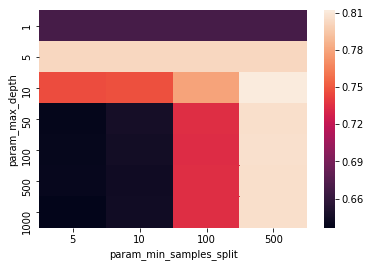

In [121]:
gsv = openfile('GridSearch_Avg_W2V_Decision_Tree')
print (gsv.best_params_)
pvt = pd.pivot_table(pd.DataFrame(gsv.cv_results_),values='mean_test_score', index='param_max_depth', columns='param_min_samples_split')
sns.heatmap(pvt)

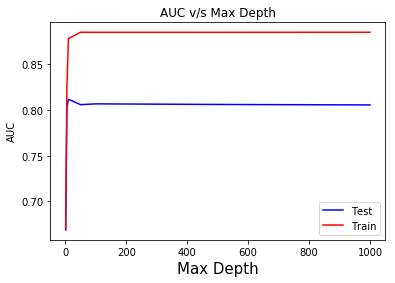

In [23]:
gsv = openfile('GridSearch_Avg_W2V_Decision_Tree')

x1=[]
y1=[]
x2=[]
y2=[]
gsv.cv_results_
means = gsv.cv_results_['mean_test_score']
means_train = gsv.cv_results_['mean_train_score']
stds = gsv.cv_results_['std_test_score']
for mean, mean_train ,  std, params in zip(means, means_train,stds, gsv.cv_results_['params']):

    if params['min_samples_split'] == 500:
        x1.append(params['max_depth'])
        y1.append(mean)
        x2.append(params['max_depth'])
        y2.append(mean_train)

        

plt.xlabel("Max Depth",fontsize=15)
plt.ylabel("AUC")
plt.title('AUC v/s Max Depth')

plt.plot(x1,y1,'b',label="Test")
plt.plot(x2,y2,'r',label="Train")
plt.legend()
plt.show()

In [122]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

gsv = openfile('GridSearch_Avg_W2V_Decision_Tree')
max_depth_best = gsv.best_params_['max_depth']
min_samples_split_best = gsv.best_params_['min_samples_split']
model = DecisionTreeClassifier(class_weight = 'balanced' , max_depth=max_depth_best , min_samples_split=min_samples_split_best)

# fitting the model
model.fit(reviews_train_w2v , reviews_score_train_w2v)

# predict the response
pred = model.predict(reviews_train_w2v)
savefile(model,'AVG_W2V_Decision_Tree_Model_Train')
# evaluate accuracy
acc = accuracy_score(reviews_score_train_w2v, pred) * 100
print('\nThe accuracy of the Decision Tree for max_depth = %f is %f%%' % (max_depth_best, acc))


The accuracy of the Decision Tree for max_depth = 10.000000 is 77.102857%


AUC: 0.806


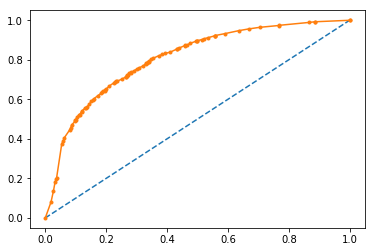

In [123]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot
model = openfile('AVG_W2V_Decision_Tree_Model_Test')
#Getting AUC value from calibrated model . 
probs = model.predict_proba(reviews_train_w2v)
probs = probs[:, 1]
auc = roc_auc_score(reviews_score_train_w2v, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(reviews_score_train_w2v, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

[[ 7145  1461]
 [14567 46827]]


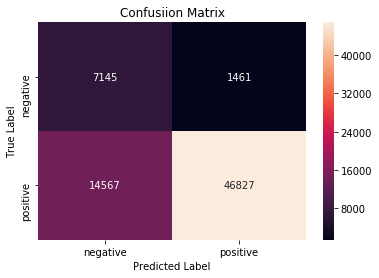

In [124]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(reviews_score_train_w2v, pred)
print (conf_matrix)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [125]:
from sklearn.metrics import classification_report
print (classification_report(reviews_score_train_w2v, pred))

              precision    recall  f1-score   support

           0       0.33      0.83      0.47      8606
           1       0.97      0.76      0.85     61394

   micro avg       0.77      0.77      0.77     70000
   macro avg       0.65      0.80      0.66     70000
weighted avg       0.89      0.77      0.81     70000



In [126]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

gsv = openfile('GridSearch_Avg_W2V_Decision_Tree')
max_depth_best = gsv.best_params_['max_depth']
min_samples_split_best = gsv.best_params_['min_samples_split']
model = DecisionTreeClassifier(class_weight = 'balanced' , max_depth=max_depth_best , min_samples_split=min_samples_split_best)

# fitting the model
model.fit(reviews_test_w2v , reviews_score_test_w2v)

# predict the response
pred = model.predict(reviews_test_w2v)
savefile(model,'AVG_W2V_Decision_Tree_Model_Test')
# evaluate accuracy
acc = accuracy_score(reviews_score_test_w2v, pred) * 100
print('\nThe accuracy of the Decision Tree for max_depth = %f is %f%%' % (max_depth_best, acc))


The accuracy of the Decision Tree for max_depth = 10.000000 is 75.696667%


AUC: 0.874


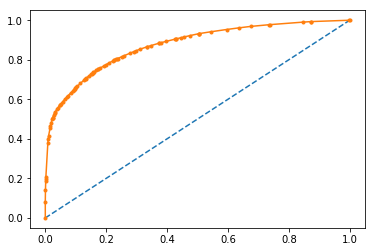

In [127]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot
model = openfile('AVG_W2V_Decision_Tree_Model_Test')
#Getting AUC value from calibrated model . 
probs = model.predict_proba(reviews_test_w2v)
probs = probs[:, 1]
auc = roc_auc_score(reviews_score_test_w2v, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(reviews_score_test_w2v, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

[[ 3049   616]
 [ 6675 19660]]


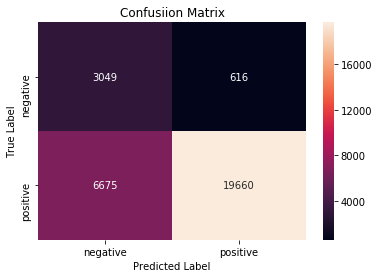

In [128]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(reviews_score_test_w2v, pred)
print (conf_matrix)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [130]:
from sklearn.metrics import classification_report
print (classification_report(reviews_score_test_w2v, pred))

              precision    recall  f1-score   support

           0       0.31      0.83      0.46      3665
           1       0.97      0.75      0.84     26335

   micro avg       0.76      0.76      0.76     30000
   macro avg       0.64      0.79      0.65     30000
weighted avg       0.89      0.76      0.80     30000



## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [74]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(reviews_train['CleanedText'].values)
# print (reviews_train.shape)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# print (dictionary)

In [75]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(reviews_train['CleanedText'].values): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(' '): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
# print (tfidf_sent_vectors)
print (type(tfidf_sent_vectors))

100%|██████████| 70000/70000 [01:48<00:00, 644.66it/s]

<class 'list'>


In [76]:
tfidf_sent_vectors = np.array(tfidf_sent_vectors)
print (tfidf_sent_vectors.shape)
# print (tfidf_sent_vectors[0])

(70000, 300)


In [77]:
savefile(tfidf_sent_vectors , 'tfidf_W2V_Decision_Tree_2')

In [78]:

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

tfidf_sent_vectors = gsv = openfile("tfidf_W2V_Decision_Tree_2")

tfidfw2v_vecs_norm =  tfidf_sent_vectors

#Not shuffling the data as we want it on time basis


In [79]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score
    
    
clf = DecisionTreeClassifier(  class_weight = 'balanced' )
param_grid = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split' : [5, 10, 100, 500] }
#Using GridSearchCV
model = GridSearchCV(clf, param_grid, scoring = 'roc_auc', cv=5 , verbose=1 ,n_jobs=-2)
model.fit(tfidfw2v_vecs_norm, reviews_score_train)
savefile(model,"GridSearch_tfidf_w2v_Decision_Tree")
print(model.best_estimator_)
print(model.score(tfidfw2v_vecs_norm, reviews_score_train))    
# weight = model.coef_
    
 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-2)]: Done 140 out of 140 | elapsed: 18.0min finished


DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.8581664036385838


{'max_depth': 10, 'min_samples_split': 500}


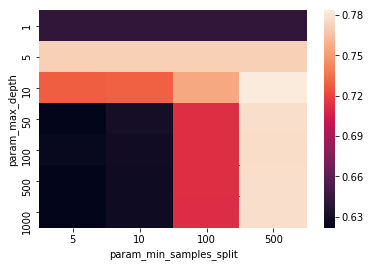

In [131]:
gsv = openfile('GridSearch_tfidf_w2v_Decision_Tree')
print (gsv.best_params_)
pvt = pd.pivot_table(pd.DataFrame(gsv.cv_results_),values='mean_test_score', index='param_max_depth', columns='param_min_samples_split')
sns.heatmap(pvt)

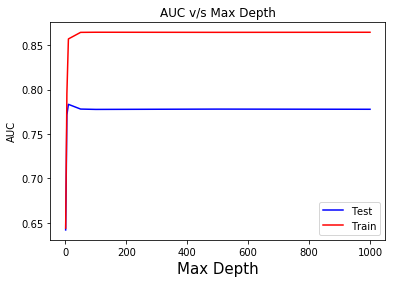

In [24]:
gsv = openfile('GridSearch_tfidf_w2v_Decision_Tree')

x1=[]
y1=[]
x2=[]
y2=[]
gsv.cv_results_
means = gsv.cv_results_['mean_test_score']
means_train = gsv.cv_results_['mean_train_score']
stds = gsv.cv_results_['std_test_score']
for mean, mean_train ,  std, params in zip(means, means_train,stds, gsv.cv_results_['params']):

    if params['min_samples_split'] == 500:
        x1.append(params['max_depth'])
        y1.append(mean)
        x2.append(params['max_depth'])
        y2.append(mean_train)

        

plt.xlabel("Max Depth",fontsize=15)
plt.ylabel("AUC")
plt.title('AUC v/s Max Depth')

plt.plot(x1,y1,'b',label="Test")
plt.plot(x2,y2,'r',label="Train")
plt.legend()
plt.show()

In [132]:

from sklearn.metrics import accuracy_score
gsv = openfile("GridSearch_tfidf_w2v_Decision_Tree")


max_depth_best = gsv.best_params_['max_depth']
min_samples_split_best = gsv.best_params_['min_samples_split']
model = DecisionTreeClassifier(class_weight = 'balanced' , max_depth=max_depth_best , min_samples_split=min_samples_split_best)
# fitting the model
model.fit(tfidfw2v_vecs_norm , reviews_score_train)

# predict the response
pred = model.predict(tfidfw2v_vecs_norm)
savefile(model,'AVGW2V_TFIDF_DECISION_TREE_TRAIN')
# evaluate accuracy
acc = accuracy_score(reviews_score_train, pred) * 100
print('\nThe accuracy of the Decision Tree for max_depth = %f is %f%%' % (max_depth_best, acc))


The accuracy of the Decision Tree for max_depth = 10.000000 is 74.211429%


AUC: 0.757


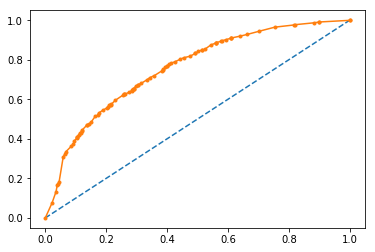

In [133]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot
model = openfile('AVG_W2V_Decision_Tree_Model_Test')
#Getting AUC value from calibrated model . 
probs = model.predict_proba(tfidfw2v_vecs_norm)
probs = probs[:, 1]
auc = roc_auc_score(reviews_score_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(reviews_score_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

[[ 7035  1571]
 [16481 44913]]


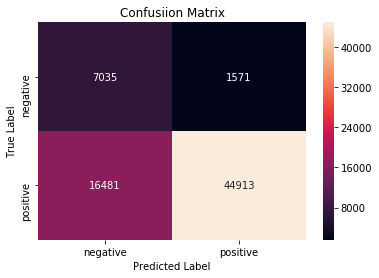

In [134]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(reviews_score_train, pred)
print (conf_matrix)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [135]:
from sklearn.metrics import classification_report
print (classification_report(reviews_score_train, pred))

              precision    recall  f1-score   support

           0       0.30      0.82      0.44      8606
           1       0.97      0.73      0.83     61394

   micro avg       0.74      0.74      0.74     70000
   macro avg       0.63      0.77      0.64     70000
weighted avg       0.88      0.74      0.78     70000



# [6] Conclusions

### Performance Table :

In [137]:
models = pd.DataFrame({'Model': ['Bow', "TFIDF" ,"AVG W2V" ,  "TFIDF-W2V" ], 'Max_Depth': [50,50,10,10], 'Min_samples_split':[500,500,500,500] ,  'AUC': [0.895,0.918,0.874,0.75], 'Accuracy': [74,80.3,75.69,74.21]}, columns = ["Model", "Max_Depth","Min_samples_split", "AUC", 'Accuracy'])
models

,Model,Max_Depth,Min_samples_split,AUC,Accuracy
0,Bow,50,500,0.895,74.00
1,TFIDF,50,500,0.918,80.30
2,AVG W2V,10,500,0.874,75.69
3,TFIDF-W2V,10,500,0.750,74.21


 - TFIDF Gives the best AUC Score and Accuracy .
 - Used Graphviz to plot a Graph with features and gini values . 
 - We can improve the AUC and Accuracy by using Random Forests .